# 2.4 Learning Cost Function for Optimal Transport

arXiv:2002.09650v2

In [1]:
import math
import time
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.sparse import random as sparserandom
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from gensim.models import KeyedVectors, word2vec 
from google.colab import files


In [2]:
!brew install wget
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz

/bin/bash: brew: command not found
--2021-10-25 20:07:51--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.90.230
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.90.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  51.4MB/s    in 34s     

2021-10-25 20:08:26 (45.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [3]:
# Parameters
n = 50
m = 50
n_iter = 500
eps = 1.3
eps_num = 0.00001 # num issues

# FORWARD

In [4]:
def euclid_dist(point_a, point_b):
  return np.linalg.norm(np.subtract(point_a,point_b))

def distances(distr_1, distr_2):
  n, m = distr_1.shape[0], distr_2.shape[0]
  distances = np.zeros((n,m))
  for i in range(n):
    for j in range(m):
      distances[i][j] = euclid_dist(distr_1[i], distr_2[j])
  return distances

def matrix_of_constraints(n, m):
  A = np.zeros(shape=(n+m, n*m))
  for i in range(n):
    for j in range(m):
      A[i][i*m+j] = 1
  for i in range(m):
    for j in range(n):
      A[n+i][i+j*m] = 1
  return A

def vector_of_constraints(n, m): # equal masses for now
  ret = np.ones(n+m)
  ret[:n] *= 1/n
  ret[n:] *= 1/m
  return ret

def timer(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        rez = func(*args, **kwargs)
        print(f"For n = {n} the whole optimization took:", time.time() - start)
        return rez
    return wrapper

In [5]:
@timer
def optimal_transport(n, m):
  distr_1 = np.random.random((n,2)) + 0.75
  distr_2 = distr_1 + (np.random.random((m,2))-0.5)/5
  distr_1_class = np.append(distr_1, np.zeros((n,1)), axis=1)
  distr_2_class = np.append(distr_2, np.ones((m,1)), axis=1)
  # equal masses
  distr_1_everything = np.append(distr_1_class, (1/n) * np.ones((n,1)), axis=1)
  distr_2_everything = np.append(distr_2_class, (1/m) * np.ones((m,1)), axis=1)

  c = distances(distr_1,distr_2).flatten()
  A_eq = matrix_of_constraints(n,m)
  b_eq = vector_of_constraints(n, m)
  bounds=tuple(zip([0]*(n*m),[1]*(n*m)))
  initial_guess = (1/(n*m)*np.ones((n, m))).flatten()

  start = time.time()
  res = optimize.linprog(c = c, A_eq = A_eq, b_eq = b_eq, bounds = bounds, x0 = initial_guess)
  time_only_linprog = time.time()-start
  
  return (distr_1_everything, distr_2_everything, res, time_only_linprog, c)

In [6]:
n=50
m=50

(distr_1_everything, distr_2_everything, res, time_only_linprog, real_cost) = optimal_transport(n,m)
transport = res.x.reshape((m,n))

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog.py:514: OptimizeWarning: x0 is used only when method is 'revised simplex'. 
  warn(warning_message, OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


For n = 50 the whole optimization took: 33.67519426345825


In [7]:
optimal_transport_transition = np.round_(res.x.reshape((n,m)), decimals=4)
optimal_transport_everything1 = np.append(distr_1_everything, optimal_transport_transition, axis=1)
optimal_transport_everything2 = np.append(distr_2_everything, optimal_transport_transition.T, axis=1)

Regularization

In [8]:
def Sinkhorn(C,a,b,gamma,niter = 500):
    K=np.exp(-C/gamma)
    v=np.ones(b.size)
    for it in range(niter):
        u=a/(np.dot(K,v))
        v=b/(np.dot(K.T,u))
    P = np.dot(np.diag(u),np.dot(K,np.diag(v)))
    return P

In [9]:
# assume equal masses
a = np.ones(n)*1/n
b = np.ones(m)*1/m
epsilon = 0.15
n_iter = 1000
transport_sink = Sinkhorn(real_cost.reshape((n,m)), a, b, epsilon, n_iter)

# INVERSE

In [10]:
def get_toy_cost_pi_marginals(n,m,epsilon):
  a = np.ones(n)*1/n 
  b = np.ones(m)*1/m
  C = pd.DataFrame(np.random.random(((n,m))))
  for i in range(n):
    for j in range(m):
      C.loc[i,j]= abs((i-j)/n)
  return Sinkhorn(C,a,b,epsilon),np.array(C)

def get_toy_matrix(n,m):
  return sparserandom(n, m, density=0.2, data_rvs=np.ones).A
  
def normalize_get_marginals(T):
  N = np.sum(T)
  T /= N + eps_num
  mu = np.sum(T, axis=1)
  nu = np.sum(T, axis=0)
  return T, mu, nu

# Paper

Case for symmetric matrices and n=m. Otherwise regularization function R changes

- Input: Observed matching matrix $\hat{\pi} \in \mathbb{R}^{m \times n}$ and its marginals $\mu \in \mathbb{R}^{m}, \nu \in \mathbb{R}^{n}$.
- Initialize: $\alpha \in \mathbb{R}^{m \times 1}, \beta \in \mathbb{R}^{n \times 1}, u=\exp (\alpha / \varepsilon), v=\exp (\beta / \varepsilon), c \in \mathbb{R}^{m \times n}$
- Repeat until convergent
  - $K \leftarrow e^{-c / \varepsilon}$
  - $u \leftarrow \mu /(K v)$
  - $v \leftarrow \nu /\left(K^{\top} u\right)$
  - $K \leftarrow \hat{\pi} /\left(u v^{\top}\right)$
  - $\hat{c}\leftarrow -\varepsilon \log (K)$ 
  - $c \leftarrow \frac{\hat{c}+\hat{c}^T}{2}$
  - $c_{ii} \leftarrow 0$
- Output: $\alpha=\varepsilon \log u, \beta=\varepsilon \log v, c$

In [11]:
def algo_paper(P, mu, nu, niter = 500, eps = 10, eps_num = 0.000001):
  """
  P is mxn; mu m dim; alpha m dim; vu n dim; beta n dim
  """
  m = mu.size
  n = nu.size
  C = np.random.random((m, n))
  alpha = mu
  beta = nu
  u = np.exp(alpha/eps)
  v = np.exp(beta/eps)
  for it in range(niter):
    K=np.exp(-1/eps*C)
    u=mu/(np.dot(K,v) + eps_num)
    v=nu/(np.dot(K.T,u) + eps_num)
    K=P/(np.outer(u,v.T) + eps_num)
    C=-eps*np.log(K+eps_num)
    # optional regularization
    if n == m:
      C = (C + C.T)/2
    np.fill_diagonal(C, 0)
  return C

In [12]:
mu, nu = np.sum(transport, axis=1), np.sum(transport, axis=0)

In [14]:
C_paper = algo_paper(transport, mu, nu, n_iter, eps, eps_num)
C_paper = (np.max(real_cost) / np.max(C_paper)) * C_paper

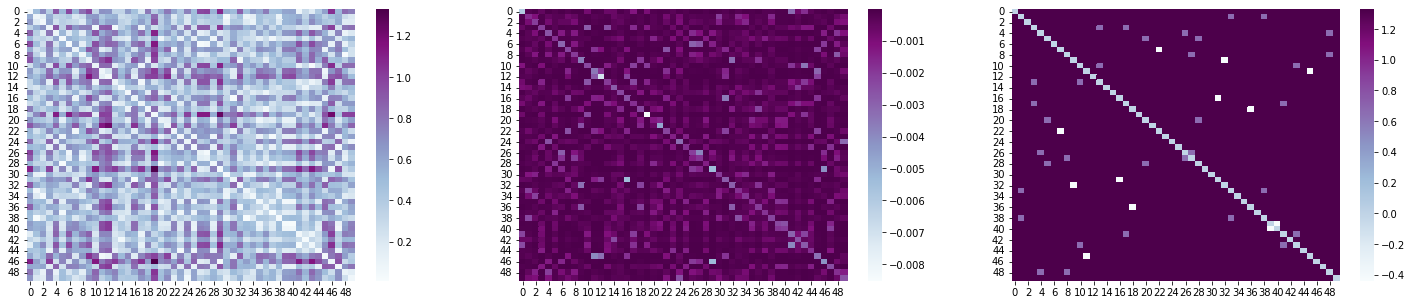

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,5))
ax1 = sns.heatmap(ax=ax1, data=real_cost.reshape((m,n)), cmap="BuPu")
ax2 = sns.heatmap(ax=ax2, data=(-1)*transport_sink, cmap="BuPu")
ax3 = sns.heatmap(ax=ax3, data=C_paper, cmap="BuPu")

# Movies-Users Data

In [20]:
uploaded = files.upload() # tags.csv

Saving tags.csv to tags.csv


In [21]:
# takes a lot of time - ml_training.csv
uploaded = files.upload()

In [ ]:
data_pandas = pd.read_csv("ml_train.csv")
data_pandas.drop(columns=["timestamp"])
data_pandas['movieId'] = pd.to_numeric(data_pandas['movieId'])
data_pandas['userId'] = pd.to_numeric(data_pandas['userId'])
data_numpy = data_pandas.values

Trucate Data

In [ ]:
num_users = int(np.max(data_numpy[:,0])/10)
num_movies = int(np.max(data_numpy[:,1])/10)
huge_negative_matrix = np.zeros((num_users, num_movies))
for i in range(data_numpy.shape[0]):
  vec = (-1)*data_numpy[i]
  if vec[0] <= num_users and vec[1] < num_movies:
    huge_negative_matrix[int(vec[0])-1][int(vec[1])-1] = vec[2]

Feature Space

In [ ]:
data_tags_pandas = pd.read_csv("tags.csv")
out = data_tags_pandas['movieId'].isin(range(num_movies))
filtered_dt = data_tags_pandas[out]
out = filtered_dt['userId'].isin(range(num_users))
filtered_tags_data_pandas = filtered_dt[out]
tags_data_numpy = filtered_tags_data_pandas.to_numpy()

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(list(filtered_tags_data_pandas['tag'].fillna("none")))
pca = TruncatedSVD(100)
X_train_counts_pca = pca.fit_transform(X_train_counts)
concat = np.concatenate((tags_data_numpy, X_train_counts_pca), axis=1)

In [26]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

Algorithm - Data Represented in Feature Spaces

In [27]:
def algo_paper(P, G, D, mu, nu, niter = 500, eps = 10, eps_num = 0.000001):
  """
  P is mxn; mu m dim; alpha m dim; vu n dim; beta n dim
  """
  m = mu.size
  n = nu.size
  C = np.random.random((m, n))
  alpha = mu # np.random.random((m,))
  beta = nu # np.random.random((n,))
  u = np.exp(alpha/eps)
  v = np.exp(beta/eps)
  G_pseudoinv_trans = np.linalg.pinv(G)
  D_pseudoinv = np.linalg.pinv(D)
  for it in range(niter):
    K=np.exp(-1/eps*C)
    u=mu/(np.dot(K,v) + eps_num)
    v=nu/(np.dot(K.T,u) + eps_num)
    K=P/(np.outer(u,v.T) + eps_num)
    C=-eps*np.log(K+eps_num)
    C = G_psudoinv_trans @ C @ D_pseudoinv
  return C